Source: https://github.com/BeeAlarmed/BeeAlarmed

# Imports

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import config as cfg
import matplotlib.pyplot as plt

Constants

In [4]:
CHAN_DIM = -1


# Model

In [5]:
def build_varroa_branch(input_shape):
    """! Creates the branch that detects varroa mite infestations
    """
    tmp_layer= layers.experimental.preprocessing.Rescaling(1./255)(input_shape)
    tmp_layer= Conv2D(64, (4, 4), padding="valid")(tmp_layer)
    tmp_layer= Activation("relu")(tmp_layer)
    tmp_layer= BatchNormalization(axis=CHAN_DIM)(tmp_layer)
    tmp_layer= MaxPooling2D(pool_size=(2, 2))(tmp_layer)

    tmp_layer= Conv2D(32, (3, 3), padding="valid")(tmp_layer)
    tmp_layer= Activation("relu")(tmp_layer)
    tmp_layer= MaxPooling2D(pool_size=(2, 2))(tmp_layer)

    tmp_layer= Conv2D(16, (3, 3), padding="valid")(tmp_layer)
    tmp_layer= Activation("relu")(tmp_layer)
    tmp_layer= MaxPooling2D(pool_size=(2, 2))(tmp_layer)

    tmp_layer= Flatten()(tmp_layer)
    tmp_layer= BatchNormalization(axis=CHAN_DIM)(tmp_layer)
    tmp_layer= Dense(1)(tmp_layer)
    tmp_layer= Activation("sigmoid", name="varroa_output")(tmp_layer)

    return tmp_layer


In [6]:
def build_pollen_branch(input_shape):
    """! Creates the branch that detects pollen packets
    """
    tmp_layer= layers.experimental.preprocessing.Rescaling(1./255)(input_shape)
    tmp_layer= Conv2D(32, (4, 4), padding="valid")(tmp_layer)
    tmp_layer= Activation("relu")(tmp_layer)
    tmp_layer= BatchNormalization(axis=CHAN_DIM)(tmp_layer)
    tmp_layer= MaxPooling2D(pool_size=(2, 2))(tmp_layer)

    tmp_layer= Conv2D(16, (3, 3), padding="valid")(tmp_layer)
    tmp_layer= Activation("relu")(tmp_layer)
    tmp_layer= MaxPooling2D(pool_size=(2, 2))(tmp_layer)

    tmp_layer= Flatten()(tmp_layer)
    tmp_layer= BatchNormalization(axis=CHAN_DIM)(tmp_layer)
    tmp_layer= Dense(1)(tmp_layer)
    tmp_layer= Activation("sigmoid", name="pollen_output")(tmp_layer)

    return tmp_layer


In [7]:
def build_wasps_branch(input_shape):
    """! Creates the branch that detects wasps
    """
    tmp_layer= layers.experimental.preprocessing.Rescaling(1./255)(input_shape)
    tmp_layer= Conv2D(16, (4, 4), padding="valid")(tmp_layer)
    tmp_layer= Activation("relu")(tmp_layer)
    tmp_layer= BatchNormalization(axis=CHAN_DIM)(tmp_layer)
    tmp_layer= MaxPooling2D(pool_size=(2, 2))(tmp_layer)

    tmp_layer= Conv2D(8, (3, 3), padding="valid")(tmp_layer)
    tmp_layer= Activation("relu")(tmp_layer)
    tmp_layer= MaxPooling2D(pool_size=(2, 2))(tmp_layer)

    tmp_layer= Flatten()(tmp_layer)
    tmp_layer= BatchNormalization()(tmp_layer)
    tmp_layer= Dense(1)(tmp_layer)
    tmp_layer= Activation("sigmoid", name="wasps_output")(tmp_layer)

    return tmp_layer


In [8]:
def build_cooling_branch(input_shape):
    """! Created the branch that detects bees that are cooling the hive
    """
    tmp_layer= layers.experimental.preprocessing.Rescaling(1./255)(input_shape)
    tmp_layer= Conv2D(64, (2, 2), padding="valid")(tmp_layer)
    tmp_layer= Activation("relu")(tmp_layer)
    tmp_layer= BatchNormalization(axis=CHAN_DIM)(tmp_layer)
    tmp_layer= MaxPooling2D(pool_size=(2, 2))(tmp_layer)

    tmp_layer= Conv2D(32, (3, 3), padding="valid")(tmp_layer)
    tmp_layer= Activation("relu")(tmp_layer)
    tmp_layer= MaxPooling2D(pool_size=(2, 2))(tmp_layer)

    tmp_layer= Conv2D(16, (2, 2), padding="valid")(tmp_layer)
    tmp_layer= Activation("relu")(tmp_layer)
    tmp_layer= MaxPooling2D(pool_size=(2, 2))(tmp_layer)

    tmp_layer= Flatten()(tmp_layer)
    tmp_layer= BatchNormalization(axis=CHAN_DIM)(tmp_layer)
    tmp_layer= Dense(1)(tmp_layer)
    tmp_layer= Activation("sigmoid", name="cooling_output")(tmp_layer)

    return tmp_layer


In [9]:
def get_bee_model(img_height, img_width):
    """! Creates BeeModel and returns it
    """
    input_shape = (img_height, img_width, 3)
    inputs = Input(shape=input_shape, name="input")

    pollen_m = build_pollen_branch(inputs)
    varroa_m = build_varroa_branch(inputs)
    wasps_m = build_wasps_branch(inputs)
    cooling_m = build_cooling_branch(inputs)

    model = Model(
        inputs=inputs,
        outputs=[varroa_m, pollen_m, wasps_m, cooling_m],
        name="beenet")

    losses = {
            "varroa_output": tf.losses.BinaryCrossentropy(),
            "pollen_output": tf.losses.BinaryCrossentropy(),
            "wasps_output": tf.losses.BinaryCrossentropy(),
            "cooling_output": tf.losses.BinaryCrossentropy()
            }
    loss_weights = {
            "varroa_output": 1.0,
            "pollen_output": 1.0,
            "wasps_output": 1.0,
            "cooling_output": 1.0
            }

    opt = Adam(learning_rate=0.0005)

    model.compile(
         optimizer=opt,
         loss=losses,
         metrics=["accuracy"],
         loss_weights=loss_weights,
         )

    return model

In [10]:
model = get_bee_model(150, 75)

In [11]:
model.summary()

Model: "beenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 150, 75, 3)]         0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 75, 3)           0         ['input[0][0]']               
                                                                                                  
 rescaling_3 (Rescaling)     (None, 150, 75, 3)           0         ['input[0][0]']               
                                                                                                  
 conv2d_2 (Conv2D)           (None, 147, 72, 64)          3136      ['rescaling_1[0][0]']         
                                                                                             

# Training

In [ ]:
train, val = tfds.load('bee_dataset/bee_dataset_150',
                   batch_size=11,
                   as_supervised=True,
                   split=["train[0%:50%]", "train[50%:100%]"])

In [13]:
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    verbose=1,
    callbacks=[]
)

Epoch 1/20
341/341 [==============================] - 39s 47ms/step - loss: 0.9928 - varroa_output_loss: 0.4392 - pollen_output_loss: 0.2365 - wasps_output_loss: 0.1180 - cooling_output_loss: 0.1991 - varroa_output_accuracy: 0.7976 - pollen_output_accuracy: 0.9017 - wasps_output_accuracy: 0.9557 - cooling_output_accuracy: 0.9284 - val_loss: 1.9257 - val_varroa_output_loss: 1.1580 - val_pollen_output_loss: 0.2062 - val_wasps_output_loss: 0.3086 - val_cooling_output_loss: 0.2529 - val_varroa_output_accuracy: 0.8334 - val_pollen_output_accuracy: 0.9330 - val_wasps_output_accuracy: 0.8809 - val_cooling_output_accuracy: 0.9501
Epoch 2/20
341/341 [==============================] - 12s 36ms/step - loss: 0.5293 - varroa_output_loss: 0.3099 - pollen_output_loss: 0.1340 - wasps_output_loss: 0.0172 - cooling_output_loss: 0.0683 - varroa_output_accuracy: 0.8662 - pollen_output_accuracy: 0.9535 - wasps_output_accuracy: 0.9957 - cooling_output_accuracy: 0.9778 - val_loss: 0.8282 - val_varroa_output_

In [14]:
output_names = [f'{n}_output' for n in ('varroa', 'pollen', 'wasps', 'cooling')]

losses = [history.history[f'{o}_loss'] for o in output_names]
val_losses = [history.history[f'val_{o}_loss'] for o in output_names]
accs = [history.history[f'{o}_accuracy'] for o in output_names]
val_accs = [history.history[f'val_{o}_accuracy'] for o in output_names]

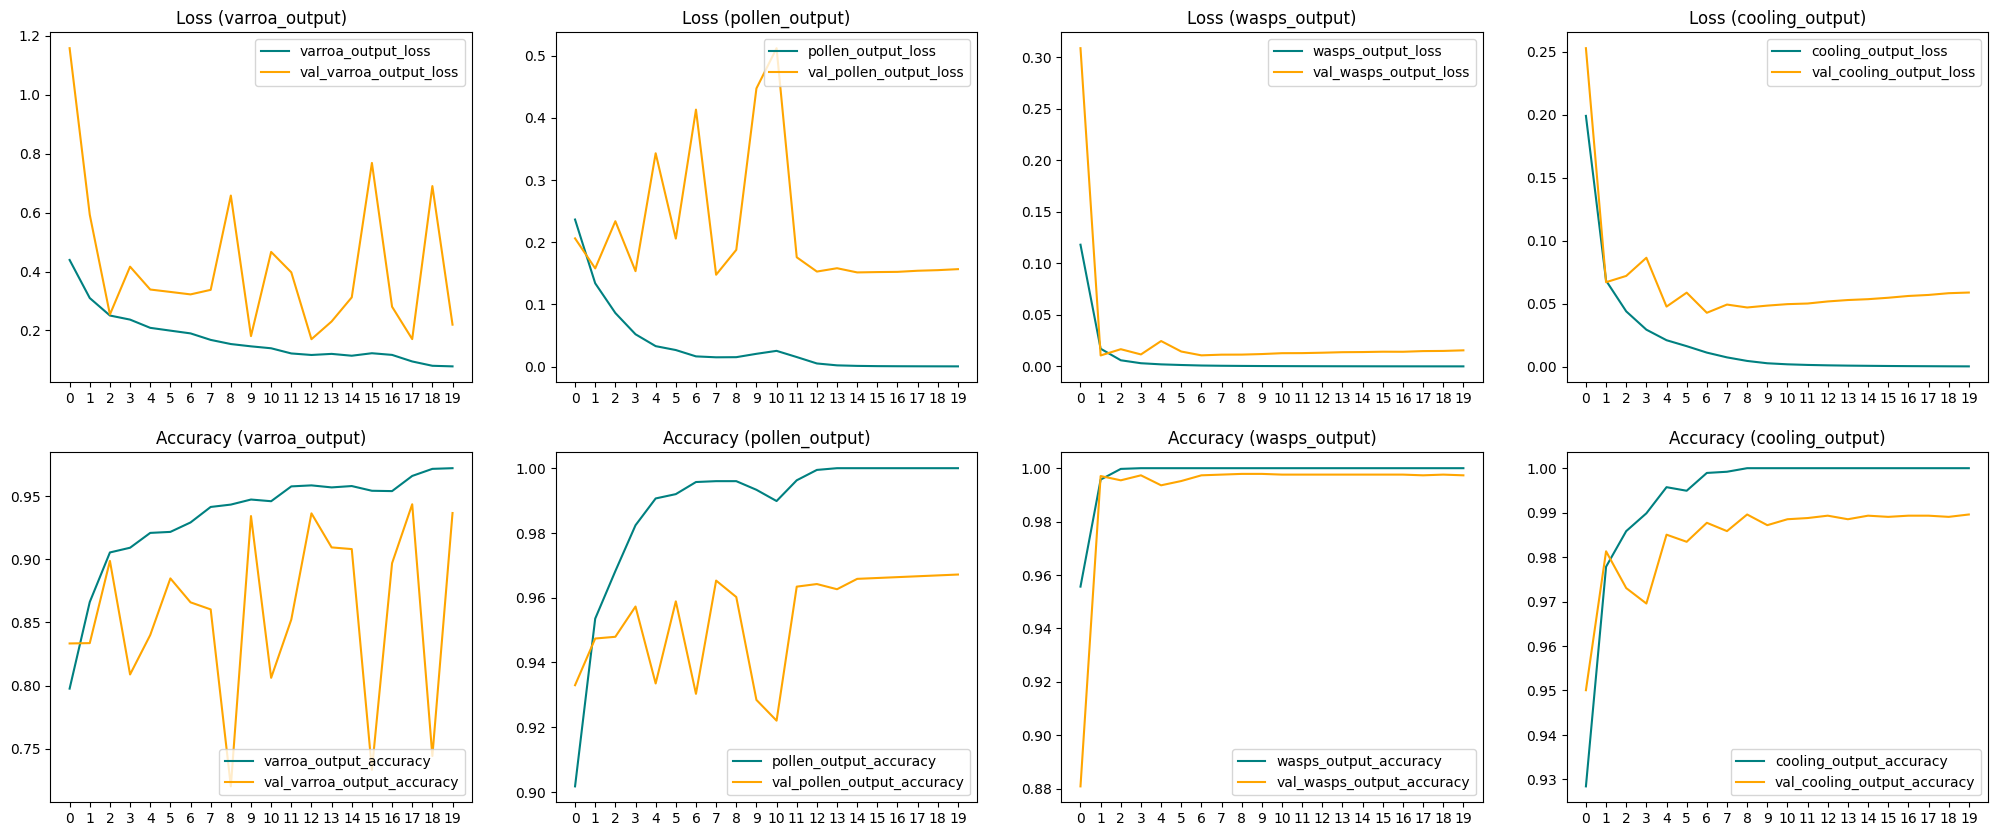

In [15]:
plt.figure(figsize=(25, 10))

for i, (name, loss, val_loss) in enumerate(zip(output_names, losses, val_losses)):
  plt.subplot(2, 4, i + 1)
  plt.plot(loss, color='teal', label=f'{name}_loss')
  plt.plot(val_loss, color='orange', label=f'val_{name}_loss')
  plt.xticks(range(history.epoch[-1] + 1))
  plt.legend(loc='upper right')
  plt.title(f'Loss ({name})')

for i, (name, acc, val_acc) in enumerate(zip(output_names, accs, val_accs)):
  plt.subplot(2, 4, i + 5)
  plt.plot(acc, color='teal', label=f'{name}_accuracy')
  plt.plot(val_acc, color='orange', label=f'val_{name}_accuracy')
  plt.xticks(range(history.epoch[-1] + 1))
  plt.legend(loc='lower right')
  plt.title(f'Accuracy ({name})')

plt.show()

In [16]:
model.save(cfg.MODEL_SAVE_PATH)